In [1]:
! pip install fuzzywuzzy python-Levenshtein deep-translator

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import nltk
import difflib
from fuzzywuzzy import fuzz

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from transformers import (
    XLMRobertaTokenizerFast,
    XLMRobertaForTokenClassification,
    get_scheduler
)
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from deep_translator import GoogleTranslator

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# IHQID_1mg_train_path = "indic-health-demo/Dataset/IHQID-1mg/train.csv"
# IHQID_1mg_test_path = "indic-health-demo/Dataset/IHQID-1mg/test.csv"

IHQID_WebMD_train_path = "indic-health-demo/Dataset/IHQID-WebMD/train.csv"
IHQID_WebMD_test_path = "indic-health-demo/Dataset/IHQID-WebMD/test.csv"


IHQID_train = pd.read_csv(IHQID_WebMD_train_path)[['question_hindi', 'disease_hindi', 'drug_hindi', 'treatment_hindi']]
IHQID_test = pd.read_csv(IHQID_WebMD_test_path)[['question_hindi', 'disease_hindi', 'drug_hindi', 'treatment_hindi']]


# GENERATING TAGS

In [4]:
def get_common_sequence(tokenized_sentence, tokenized_entity, entity, tag_list):
    contiguous_indices = {
        "similarity": 0.0,
        "index_start": -1,
        "index_end": -1
    }
    target_length = len(tokenized_entity)
    sentence_length = len(tokenized_sentence)

    for i in range(sentence_length - target_length + 1):
        # Target length = target length
        fuzz_ratio = fuzz.ratio(tokenized_entity, tokenized_sentence[i:i + target_length])
        
        if fuzz_ratio >= 80 and contiguous_indices["similarity"] < fuzz_ratio:
            contiguous_indices["similarity"] = fuzz_ratio
            contiguous_indices["index_start"] = i
            contiguous_indices["index_end"] = i + target_length - 1
            
        # Target length = target length - 1
        fuzz_ratio = fuzz.ratio(tokenized_entity, tokenized_sentence[i:i + target_length - 1])
        
        if fuzz_ratio >= 80 and contiguous_indices["similarity"] < fuzz_ratio:
            # To take care of when tokenization increased the number of tokens [Eg - (1000mg/ mg) vs (1000mg/mg)]
            contiguous_indices["similarity"] = fuzz_ratio
            contiguous_indices["index_start"] = i
            contiguous_indices["index_end"] = i + target_length - 2
            
    tag_list[contiguous_indices["index_start"]] = "B-" + entity
    for index in range(contiguous_indices["index_start"] + 1, contiguous_indices["index_end"] + 1):
        tag_list[index] = "I-" + entity

In [5]:
IHQID_train['tags_hindi'] = IHQID_train['question_hindi']

for i in range(len(IHQID_train)):
    
    tokenized_sentence = word_tokenize(IHQID_train['question_hindi'][i].lower())
    
    tag_list = ['O' for token in tokenized_sentence]
    
    tokenized_diseases = []
    tokenized_drugs = []
    tokenized_treatments = []
    
    if type(IHQID_train['disease_hindi'][i]) is not float:
        tokenized_diseases = [word_tokenize(entity.lower()) for entity in IHQID_train['disease_hindi'][i].split(',')]
        for tokenized_disease in tokenized_diseases:
            get_common_sequence(tokenized_sentence, tokenized_disease, "disease", tag_list)
    else:
        assert(math.isnan(IHQID_train['disease_hindi'][i]))
        
    if type(IHQID_train['drug_hindi'][i]) is not float:
        tokenized_drugs = [word_tokenize(entity.lower()) for entity in IHQID_train['drug_hindi'][i].split(',')]
        for tokenized_drug in tokenized_drugs:
            get_common_sequence(tokenized_sentence, tokenized_drug, "drug", tag_list)
    else:
        assert(math.isnan(IHQID_train['drug_hindi'][i]))
    
    if type(IHQID_train['treatment_hindi'][i]) is not float:
        tokenized_treatments = [word_tokenize(entity.lower()) for entity in IHQID_train['treatment_hindi'][i].split(',')]
        for tokenized_treatment in tokenized_treatments:
            get_common_sequence(tokenized_sentence, tokenized_treatment, "treatment", tag_list)
    else:
        assert(math.isnan(IHQID_train['treatment_hindi'][i]))

    IHQID_train['question_hindi'][i] = tokenized_sentence
    IHQID_train['tags_hindi'][i] = tag_list

In [6]:
IHQID_test['tags_hindi'] = IHQID_test['question_hindi']

for i in range(len(IHQID_test)):
    
    tokenized_sentence = word_tokenize(IHQID_test['question_hindi'][i].lower())
    
    tag_list = ['O' for token in tokenized_sentence]
    
    tokenized_diseases = []
    tokenized_drugs = []
    tokenized_treatments = []
    
    if type(IHQID_test['disease_hindi'][i]) is not float:
        tokenized_diseases = [word_tokenize(entity.lower()) for entity in IHQID_test['disease_hindi'][i].split(',')]
        for tokenized_disease in tokenized_diseases:
            get_common_sequence(tokenized_sentence, tokenized_disease, "disease", tag_list)
    else:
        assert(math.isnan(IHQID_test['disease_hindi'][i]))
        
    if type(IHQID_test['drug_hindi'][i]) is not float:
        tokenized_drugs = [word_tokenize(entity.lower()) for entity in IHQID_test['drug_hindi'][i].split(',')]
        for tokenized_drug in tokenized_drugs:
            get_common_sequence(tokenized_sentence, tokenized_drug, "drug", tag_list)
    else:
        assert(math.isnan(IHQID_test['drug_hindi'][i]))
    
    if type(IHQID_test['treatment_hindi'][i]) is not float:
        tokenized_treatments = [word_tokenize(entity.lower()) for entity in IHQID_test['treatment_hindi'][i].split(',')]
        for tokenized_treatment in tokenized_treatments:
            get_common_sequence(tokenized_sentence, tokenized_treatment, "treatment", tag_list)
    else:
        assert(math.isnan(IHQID_test['treatment_hindi'][i]))

    IHQID_test['question_hindi'][i] = tokenized_sentence
    IHQID_test['tags_hindi'][i] = tag_list


In [7]:
IHQID_train.head()

,question_hindi,disease_hindi,drug_hindi,treatment_hindi,tags_hindi
0,"[निस्टेटिन, किस, लिए, निर्धारित, किया, गया, है...",NaN,निस्टेटिन,NaN,"[B-drug, O, O, O, O, O, O, O]"
1,"[क्या, सम्भोग, के, बाद, डाउचिंग, मुझे, गर्भवती...",गर्भवती,NaN,NaN,"[O, O, O, O, O, O, B-disease, O, O, O, O, O, O]"
2,"[क्या, पेर्कोसेट, वजन, बढ़ने, का, कारण, बनता, है]",भार बढ़ना,पर्कोसेट,NaN,"[O, B-drug, O, O, O, B-disease, I-disease, O]"
3,"[क्या, एक, दिन, में, शराब, के, २, या, २, १/२, ...",उच्च रक्तचाप,NaN,NaN,"[O, O, O, O, O, O, O, O, O, O, O, B-disease, I..."
4,"[क्या, बहुत, अधिक, छाछ, थ्रश, का, कारण, बन, सक...",थ्रश,NaN,NaN,"[O, O, O, O, B-disease, O, O, O, O, O, O]"


In [8]:
IHQID_train.tail()

,question_hindi,disease_hindi,drug_hindi,treatment_hindi,tags_hindi
715,"[क्या, अफोर्डेबल, केयर, एक्ट, के, लिए, किसी, आ...",गर्भावस्था,NaN,NaN,"[O, O, O, O, O, O, O, O, O, B-disease, O, O, O..."
716,"[मैं, मस्सों, से, छुटकारा, पाने, के, लिए, डक्ट...",मौसा,NaN,NaN,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
717,"[बेल्स, पाल्सी, के, चेहरे, के, पक्षाघात, को, ठ...",बेल्स पाल्सी के चेहरे का पक्षाघात,NaN,चेहरे का व्यायाम,"[B-disease, I-disease, I-disease, I-disease, I..."
718,"[क्या, प्रसवपूर्व, अल्ट्रासाउंड, सुरक्षित, है, ?]",NaN,NaN,प्रसवपूर्व अल्ट्रासाउंड,"[O, B-treatment, I-treatment, O, O, O]"
719,"[मैं, सर्जरी, तक, वंक्षण, हर्निया, के, लक्षणों...",वंक्षण हर्निया,NaN,सर्जरी,"[O, B-treatment, O, B-disease, I-disease, O, O..."


In [9]:
IHQID_test.head()

,question_hindi,disease_hindi,drug_hindi,treatment_hindi,tags_hindi
0,"[हिस्टेरेक्टॉमी, के, बाद, गर्भावस्था, कितनी, आ...",गर्भवती,NaN,हीसेटेरेक्टॉमी,"[B-treatment, O, O, O, O, O, O, B-disease]"
1,"[जेनेरिक, थायराइड, दवा, कितनी, प्रभावी, है, ?]",NaN,सामान्य थायराइड दवा,NaN,"[O, O, O, O, O, O, B-drug]"
2,"[क्या, सिंगुलैर, एक, कॉर्टिकोस्टेरॉइड, है, ?]",NaN,"एकवचन, कॉर्टिकोस्टेरॉइड",NaN,"[O, O, B-drug, B-drug, O, O]"
3,"[आप, होम्योपैथिक, एयर, ड्रॉप्स, के, साथ, एडविल...",NaN,"एडविल, होम्योपैथिक ईयर ड्रॉप्स",NaN,"[O, B-drug, I-drug, I-drug, O, O, B-drug, O, O..."
4,"[क्या, बेल्स, पाल्सी, संक्रामक, है, ?]",बेल्स पाल्सी,NaN,NaN,"[O, B-disease, I-disease, O, O, O]"


In [10]:
IHQID_test.tail()

,question_hindi,disease_hindi,drug_hindi,treatment_hindi,tags_hindi
236,"[ओबामाकेयर, मेडिकेयर, प्राप्तकर्ताओं, को, कैसे...",NaN,NaN,NaN,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
237,"[पार्किंसंस, रोग, के, अध्ययन, में, एमपीटीपी, क...",पार्किंसंस रोग,NaN,एमपीटीपी,"[B-disease, I-disease, O, O, O, B-treatment, O..."
238,"[क्या, बोटोक्स, भ्रूभंग, और, झुर्रियों, के, लि...","भ्रूभंग रेखाएं, झुर्रियां",बोटोक्स,NaN,"[O, B-drug, B-disease, I-disease, B-disease, O..."
239,"[गर्भावस्था, के, दौरान, मेरा, अल्ट्रासाउंड, कब...",गर्भावस्था,NaN,अल्ट्रासाउंड,"[B-disease, O, O, O, B-treatment, O, O, O]"
240,"[क्या, न्युसिंटा, में, टाइलेनॉल, है, ?]",NaN,"न्युसिंटा, टाइलेनॉल",NaN,"[O, B-drug, O, B-drug, O, O]"


# TRAINING AND TESTING

In [11]:
label__ = {
    'O': 0,
    'B-treatment': 1,
    'I-treatment': 2,
    'B-disease': 3,
    'I-disease': 4,
    'B-drug': 5,
    'I-drug': 6
}

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model_checkpoint = "xlm-roberta-base"

hyper_parameters = {
    'batch_size': 8,
    'lr': 3e-5,
    'epochs': 10
}

cuda


In [13]:
tokenizer = XLMRobertaTokenizerFast.from_pretrained(model_checkpoint, add_prefix_space=True)

In [14]:
def process_queries(question, tag): 
    
    tokenized_input = tokenizer(question, max_length=300, padding='max_length', truncation=True, is_split_into_words=True)
    word_ids = tokenized_input.word_ids()
    for i, label in enumerate(word_ids):
        if label is None:
            word_ids[i] = 7
        else:
            word_ids[i] = label__[tag[label]]
    tokenized_input["labels"] = word_ids
    return tokenized_input

In [15]:
encoded_input_train = {
    'input_ids': [],
    'attention_mask': [],
    'tags_hindi': []
}

for index in range(len(IHQID_train['question_hindi'])):
    process_output = process_queries(IHQID_train['question_hindi'][index], IHQID_train['tags_hindi'][index])
    encoded_input_train['input_ids'].append(process_output['input_ids'])
    encoded_input_train['attention_mask'].append(process_output['attention_mask'])
    encoded_input_train['tags_hindi'].append(process_output['labels'])

encoded_input_test = {
    'input_ids': [],
    'attention_mask': [],
    'tags_hindi': []
}

for index in range(len(IHQID_test['question_hindi'])):
    process_output = process_queries(IHQID_test['question_hindi'][index], IHQID_test['tags_hindi'][index])
    encoded_input_test['input_ids'].append(process_output['input_ids'])
    encoded_input_test['attention_mask'].append(process_output['attention_mask'])
    encoded_input_test['tags_hindi'].append(process_output['labels'])

train_dataloader = DataLoader(
    TensorDataset(
        torch.tensor(encoded_input_train['input_ids']).to(device),
        torch.tensor(encoded_input_train['attention_mask']).to(device),
        torch.tensor(encoded_input_train['tags_hindi']).to(device)
    ),
    batch_size=hyper_parameters['batch_size']
)

test_dataloader = DataLoader(
    TensorDataset(
        torch.tensor(encoded_input_test['input_ids']).to(device),
        torch.tensor(encoded_input_test['attention_mask']).to(device),
        torch.tensor(encoded_input_test['tags_hindi']).to(device)
    ),
    batch_size=hyper_parameters['batch_size']
)


In [16]:
model = XLMRobertaForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label__) + 1
)
model.to(device)

optimizer = AdamW(
    model.parameters(),
    lr=hyper_parameters['lr']
)

lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=0,
  num_training_steps=hyper_parameters['epochs'] * len(train_dataloader)
)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
model.train()

updater = tqdm(range(hyper_parameters['epochs']))
for epoch in updater:
    total_train_loss = 0.0
    for batch in train_dataloader:
        
        optimizer.zero_grad()
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }
        
        outputs = model(**inputs)
        
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        
        total_train_loss += loss.item()
    
    print("Epoch:", epoch + 1, " - Training Loss:", round(total_train_loss / len(train_dataloader), 4))


# Didn't have much time to implement early stopping. So, saving the model at the end of all epochs.
torch.save(model.state_dict(), f'ee_xlmr_hi.model')


 10%|███████████████▌                                                                                                                                           | 1/10 [00:17<02:37, 17.48s/it]

Epoch: 1  - Training Loss: 0.2494


 20%|███████████████████████████████                                                                                                                            | 2/10 [00:34<02:19, 17.43s/it]

Epoch: 2  - Training Loss: 0.054


 30%|██████████████████████████████████████████████▌                                                                                                            | 3/10 [00:52<02:02, 17.54s/it]

Epoch: 3  - Training Loss: 0.051


 40%|██████████████████████████████████████████████████████████████                                                                                             | 4/10 [01:10<01:45, 17.58s/it]

Epoch: 4  - Training Loss: 0.045


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [01:27<01:28, 17.61s/it]

Epoch: 5  - Training Loss: 0.0399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 6/10 [01:45<01:10, 17.62s/it]

Epoch: 6  - Training Loss: 0.0345


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 7/10 [02:03<00:52, 17.64s/it]

Epoch: 7  - Training Loss: 0.0315


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 8/10 [02:20<00:35, 17.65s/it]

Epoch: 8  - Training Loss: 0.0265


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9/10 [02:38<00:17, 17.65s/it]

Epoch: 9  - Training Loss: 0.0241


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:56<00:00, 17.62s/it]

Epoch: 10  - Training Loss: 0.0223


In [18]:
model.eval()

prediction = []
gold_label = []

extra_appended_tokens = 0

for indexer, batch in enumerate(test_dataloader):

    inputs = {
        'input_ids': batch[0],
        'attention_mask': batch[1],
        'labels': batch[2],
    }

    with torch.no_grad():
        outputs = model(**inputs)


    gold_label_cpu = inputs['labels'].cpu().numpy()
    logits_vector = outputs.logits.detach().cpu().numpy()

    assert(len(gold_label_cpu) == len(logits_vector))

    for index in range(len(logits_vector)):
        prediction_vector = []
        for iterator__ in logits_vector[index].argmax(axis=1):
            if iterator__ != 7:
                prediction_vector.append(iterator__)
                prediction.append(iterator__)
        
        gold_label_vector = []
        for iterator__ in gold_label_cpu[index]:
            if iterator__ != 7:
                gold_label_vector.append(iterator__)
                gold_label.append(iterator__)
        
        # There are some cases (only observed once) when there was one mismatch in vector of gold label and prediction
        # To overcome that, for each tokenized sentence, append 0 to signify it not be classified as any of the entity
        while len(gold_label) < len(prediction):
            extra_appended_tokens += 1
            gold_label.append(0)
        
        while len(prediction) < len(gold_label):
            extra_appended_tokens += 1
            prediction.append(0)

print("Number of extra appended tokens : ", extra_appended_tokens)
print(classification_report(gold_label, prediction))

Number of extra appended tokens :  0
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3491
           1       0.84      0.17      0.28       154
           2       0.65      0.43      0.52        86
           3       0.62      0.64      0.63       357
           4       0.39      0.52      0.44       149
           5       0.69      0.83      0.75       356
           6       0.41      0.50      0.45        86

    accuracy                           0.83      4679
   macro avg       0.64      0.57      0.57      4679
weighted avg       0.84      0.83      0.83      4679



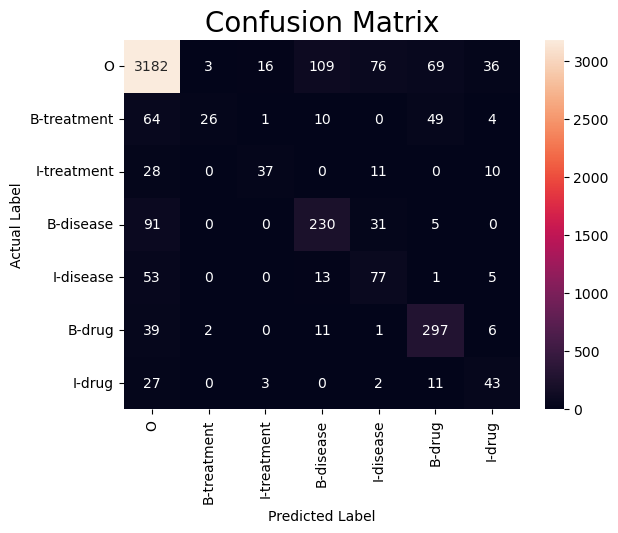

In [19]:
# Compute the confusion matrix
cm = confusion_matrix(gold_label, prediction)

# Plot the confusion matrix.
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=['O', 'B-treatment', 'I-treatment', 'B-disease', 'I-disease', 'B-drug', 'I-drug'],
    yticklabels=['O', 'B-treatment', 'I-treatment', 'B-disease', 'I-disease', 'B-drug', 'I-drug']
)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('Actual Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=20)
plt.show()